<a href="https://colab.research.google.com/github/QasimWani/simple-transformer/blob/main/transformers/kv_cache.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Simple illustration of efficiency gains with a KV cache

import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from typing import Optional
import time

In [2]:
class Cache:
  ''' Simple KV cache class '''
  def __init__(self, n, max_seq_len, h):
    # 1, n, m (growing), h
    self.K = torch.zeros(1, n, max_seq_len, h, dtype=torch.float)
    self.V = torch.zeros(1, n, max_seq_len, h, dtype=torch.float)
    self.current_pos = 0

  def get_kv(self):
    return self.K[:, :, :self.current_pos], self.V[:, :, :self.current_pos]

  def add_to_cache(self, k: torch.Tensor, v: torch.Tensor):
    self.K[:, :, self.current_pos] = k.squeeze(2)
    self.V[:, :, self.current_pos] = v.squeeze(2)
    self.current_pos += 1

  def __len__(self):
    return self.current_pos

In [3]:
class MHA(nn.Module):
    def __init__(self, d_embed: int, num_heads: int, max_seq_len: int, use_kv_cache: bool):
        super().__init__()
        assert d_embed % num_heads == 0, f"d_embed needs to be divisible by num_heads"

        self.num_heads = num_heads
        self.head_dim = d_embed // num_heads

        self.q_proj = nn.Linear(d_embed, d_embed)
        self.k_proj = nn.Linear(d_embed, d_embed)
        self.v_proj = nn.Linear(d_embed, d_embed)
        self.w_out = nn.Linear(d_embed, d_embed)

        self.register_buffer('causal_mask', torch.triu(torch.ones(1, 1, max_seq_len, max_seq_len), diagonal=1).bool())
        self.use_kv_cache = use_kv_cache
        self.cache = Cache(n=num_heads, max_seq_len=max_seq_len, h=self.head_dim)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, m, d = x.shape
        # m = 1 when using KV cache
        q = rearrange(self.q_proj(x), 'b m (n h) -> b n m h', n=self.num_heads, h=self.head_dim)
        k = rearrange(self.k_proj(x), 'b m (n h) -> b n m h', n=self.num_heads, h=self.head_dim)
        v = rearrange(self.v_proj(x), 'b m (n h) -> b n m h', n=self.num_heads, h=self.head_dim)

        mask = self.causal_mask[:, :, :m, :m]
        if self.use_kv_cache:
          self.cache.add_to_cache(k, v)
          k, v = self.cache.get_kv() # b, n, m, h

          # Incorporate mask
          k_len = k.size(2)
          mask = self.causal_mask[:, :, k_len - 1: k_len, :k_len] # query is only token and we mask out

        # Attention calculation
        scores = torch.einsum('bnqh,bnkh->bnqk', q, k) / (self.head_dim ** 0.5)
        scores = scores.masked_fill(mask, float('-inf'))

        weights = torch.softmax(scores, dim=-1)
        attention = weights @ v
        attention = rearrange(attention, 'b n q h -> b q (n h)', n=self.num_heads, h=self.head_dim)
        out = self.w_out(attention)
        return out


class FeedForward(nn.Module):
    def __init__(self, d_in, d_hidden, d_out):
        super().__init__()
        self.l1 = nn.Linear(d_in, d_hidden)
        self.gelu = nn.GELU()
        self.l2 = nn.Linear(d_hidden, d_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.l2(self.gelu(self.l1(x)))


class LearnedPositionalEncoding(nn.Module):
    def __init__(self, max_seq_len, d_embed):
        super().__init__()
        self.pos = nn.Embedding(max_seq_len, d_embed)

    def forward(self, x: torch.Tensor, start_pos: int = 0) -> torch.Tensor:
        m = x.size(1)
        positions = torch.arange(start_pos, m + start_pos, device=x.device).unsqueeze(0)
        return x + self.pos(positions)


class TransformerBlock(nn.Module):
    def __init__(self, d_embed: int, num_heads: int, max_seq_len: int, use_kv_cache: bool):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_embed)
        self.mha = MHA(d_embed, num_heads, max_seq_len, use_kv_cache)
        self.ln2 = nn.LayerNorm(d_embed)
        self.ff = FeedForward(d_embed, d_embed * 4, d_embed)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.mha(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x


class GPT(nn.Module):
    def __init__(self, vocab_size: int, d_embed: int, num_heads: int, num_layers: int, max_seq_len: int, use_kv_cache: bool):
        super().__init__()
        self.max_seq_len = max_seq_len

        self.token_emb = nn.Embedding(vocab_size, d_embed)
        self.pos_enc = LearnedPositionalEncoding(max_seq_len, d_embed)

        self.blocks = nn.ModuleList([
            TransformerBlock(d_embed, num_heads, max_seq_len, use_kv_cache) for _ in range(num_layers)
        ])

        self.ln_f = nn.LayerNorm(d_embed)
        self.head = nn.Linear(d_embed, vocab_size, bias=False)

        # Weight tying
        self.head.weight = self.token_emb.weight

        # Init weights
        self.apply(self._init_weights)

    def turn_on_kv_cache(self):
      for block in self.blocks:
          block.mha.use_kv_cache = True

    def turn_off_kv_cache(self):
      for block in self.blocks:
          block.mha.use_kv_cache = False

    def reset_cache(self):
        for block in self.blocks:
            block.mha.cache = Cache(n=block.mha.num_heads, max_seq_len=self.max_seq_len, h=block.mha.head_dim)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)

    def forward(self, idx: torch.Tensor, targets: Optional[torch.Tensor] = None, start_pos: int = 0) -> tuple:
        x = self.token_emb(idx)
        x = self.pos_enc(x, start_pos=start_pos)

        for block in self.blocks:
            x = block(x)

        x = self.ln_f(x)
        logits = self.head(x)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss

    @torch.no_grad()
    def generate(self, idx: torch.Tensor, max_new_tokens: int = 50) -> torch.Tensor:
        self.eval()
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.max_seq_len:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]  # Last position
            next_idx = logits.argmax(dim=-1, keepdim=True)  # Greedy
            idx = torch.cat((idx, next_idx), dim=1)
        return idx

    @torch.no_grad()
    def generate_with_kv_cache(self, idx: torch.Tensor, max_new_tokens: int = 50) -> torch.Tensor:
      self.eval()

      self.turn_on_kv_cache()
      self.reset_cache()

      idx_cond = idx[:, -self.max_seq_len:]
      tokens_generated = idx_cond # initial set of tokens

      for _ in range(max_new_tokens):
        start_pos = len(self.blocks[0].mha.cache) # This is crucial for ensuring each element in KV gets the correct positional encoding
        logits, _ = self(idx_cond, start_pos=start_pos)
        logits = logits[:, -1, :]  # Last position
        next_idx = logits.argmax(dim=-1, keepdim=True)  # Greedy
        tokens_generated = torch.cat((tokens_generated, next_idx), dim=1)
        # only feed the last token in the next generation step
        idx_cond = next_idx
      return tokens_generated

# Training
def train(model, data, epochs=10, batch_size=32, seq_len=64, vocab_size=100, device='cuda'):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        for i in range(0, len(data), batch_size):
          batch = data[i : i + batch_size, :]
          x = batch[:, :-1]
          y = batch[:, 1:].contiguous()

          logits, loss = model(x, y)

          optimizer.zero_grad()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          optimizer.step()

        print(f"Epoch {epoch}: Loss {loss.item():.4f}")

    return model


# Inference
def inference(model, target_data, vocab_size=100, max_new_tokens=20, device='cuda', generate_with_kv_cache: bool = False):
    model = model.to(device).eval()
    print(f"Target: {target_data[:max_new_tokens + 1].tolist()}")

    if generate_with_kv_cache:
      generated = model.generate_with_kv_cache(target_data[0].unsqueeze(0).unsqueeze(1), max_new_tokens=max_new_tokens)
    else:
      generated = model.generate(target_data[0].unsqueeze(0).unsqueeze(1), max_new_tokens=max_new_tokens)

    print(f"Generated: {generated[0].tolist()}")
    return generated

In [4]:
# Model config
vocab_size = 100
d_embed = 128
num_heads = 4
num_layers = 2
max_seq_len = 256
epochs = 5
batch_size = 32
dataset_len = 128
use_kv_cache = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GPT(
    vocab_size=vocab_size,
    d_embed=d_embed,
    num_heads=num_heads,
    num_layers=num_layers,
    max_seq_len=max_seq_len,
    use_kv_cache=use_kv_cache
)

print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

# data = torch.randint(0, vocab_size, (dataset_len, max_seq_len), device=device)
data = torch.arange(0, max_seq_len).unsqueeze(0).expand(dataset_len, -1) % vocab_size

# Train
model = train(model, data, epochs=epochs, vocab_size=vocab_size, device=device)

# Generate without KV cache
s = time.time()
tokens = inference(model, data[0], vocab_size=vocab_size, max_new_tokens=max_seq_len, device=device)
time_nokv = round(time.time() - s, 2)
print(f"No KV-cache Time taken (sec): {time_nokv}")

# Generate with KV cache
s = time.time()
model.turn_on_kv_cache()
model.reset_cache()
tokens = inference(model, data[0], vocab_size=vocab_size, max_new_tokens=max_seq_len, device=device, generate_with_kv_cache=True)
time_withkv = round(time.time() - s, 2)
print(f"With KV-cache Time taken (sec): {time_withkv}")


Parameters: 442,368
Epoch 0: Loss 3.8210
Epoch 1: Loss 3.0478
Epoch 2: Loss 2.4730
Epoch 3: Loss 1.9650
Epoch 4: Loss 1.5110
Target: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 

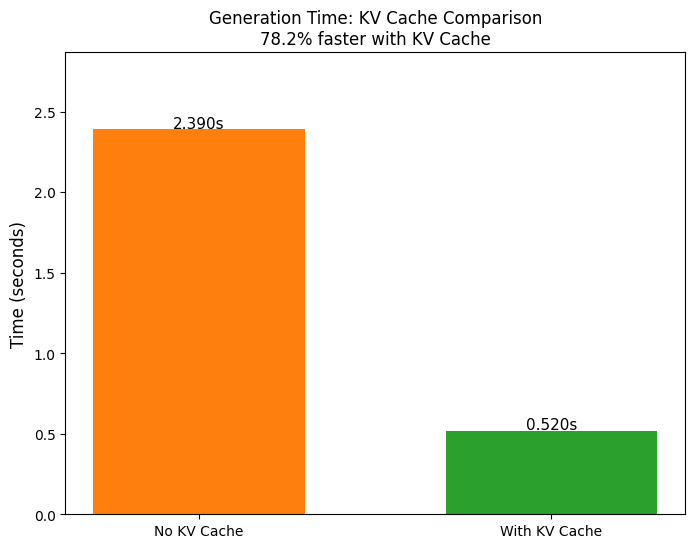

In [5]:
import matplotlib.pyplot as plt

times = [time_nokv, time_withkv]
labels = ['No KV Cache', 'With KV Cache']
speedup = ((time_nokv - time_withkv) / time_nokv) * 100

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, times, color=['#ff7f0e', '#2ca02c'], width=0.6)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title(f'Generation Time: KV Cache Comparison\n{speedup:.1f}% faster with KV Cache')
plt.ylim(0, max(times) * 1.2)
for bar, time in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{time:.3f}s', ha='center', fontsize=11)
plt.show()